### <center>**Importing All Necessary Libraries**</center>

### **Installations**

1. Activate your `Python virtual environment (if you're using one)`.

2. Open a `terminal/command prompt and navigate to your project directory`.

3. Run the following command to `generate a requirements.txt file`:

In [ ]:
#pip freeze > requirements.txt

In [401]:
# Environment variable
from dotenv import dotenv_values

# Data collection
import pyodbc  

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine learning preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold, cross_val_score
from scipy.stats import randint
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


# Model evaluation and hyperparameter tuning
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,roc_auc_score,roc_curve, fbeta_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Model persistence
import joblib

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### <center>**Data Collection**</center>

In [402]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('../.env')

# Extract database connection details from environment variables
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")
table = environment_variables.get("TABLE")

# Create the connection string for SQL Server
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

# Establish a connection to the SQL Server database
connection = pyodbc.connect(connection_string)

# Query data for 2020 from the database and load it into a DataFrame
query = f"SELECT * FROM {table}"
df1 = pd.read_sql(query, connection)

# Close the database connection
connection.close()

C:\Users\Hp\AppData\Local\Temp\ipykernel_9676\2710198086.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1 = pd.read_sql(query, connection)


In [403]:
df2 = pd.read_csv("../Data/LP2_Telco-churn-last-2000.csv")

**Merge the datasets**

In [404]:
# # Reset index of both DataFrames
# df1.reset_index(drop=True, inplace=True)
# df2.reset_index(drop=True, inplace=True)

In [405]:
data=pd.concat([df1,df2])

# display dimensionality
data.shape

(5043, 21)

**Preview dataset**

In [406]:
# display the first five rows of the dataset
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True




#### **From the summary above:**

- All columns are string except for SeniorCitizen ,tenure and MonthlyCharges
- There are missing values in several columns.

**From thoroughly examining the dataset, we came out with the following analytical questions:**

- What is the correlation between phone service and churn?
- Do charges contribute to customer churn?
- What is the average tenure of customers?
- How is customer churn aligned with whether a customer has a partner and dependents or not?
- Does being a senor citizen contribute significantly to churn?
- Is customer retention heavily dependent on customer's access to tech support?
- What effect does the online security have on tenure?
- What factors/variables significantly contribute to customer churn?

### **Hypothesis Testing**

**Hypothesis 1**
Null: Total charges do not contribute to churn rate among customers.
Alternate: Total charges significantly contribute to churn rate among customers.


### <center>**Data Preparation**</center>

**Data Cleaning**

In this Phase we are going to:
- Handle any missing values 
- Removing any duplicates 
- Removing unnecessary columns
- Handle Outliers 
- Data formatting 
- Handling inconsistent data

**Check and Handle missing values**

##### Visualizing missing Values

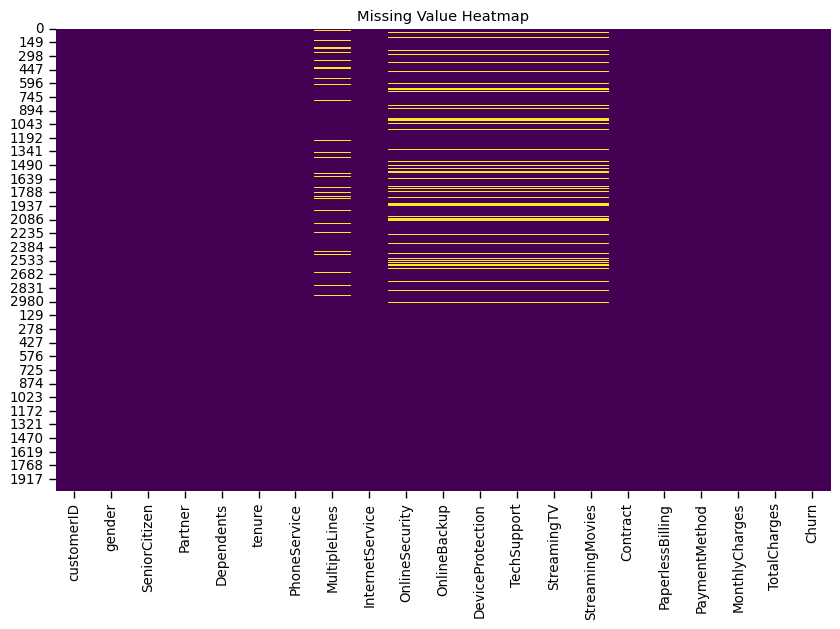

In [407]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.show()

In [408]:
# check for missing values in the dataset
data.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

**Decision**

- Given that OnlineSecurity, OnlineBackup ,DeviceProtection ,TechSupport, StreamingTV,StreamingMovies and Mutliple lines are categorical columns, instead of dropping the columns or imputing with the mode , we are going to replace them with 'No internet service' and 'No phone service' respectively.
- For the missing Churn value ,it will be dropped.

In [409]:
# fill the null categorical values with 'False'
cols_to_replace = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Replace NaN with 'No internet service' in the specified columns using applymap()
data[cols_to_replace] = data[cols_to_replace].applymap(lambda x: 'No internet service' if pd.isnull(x) else x)

# Replace NaN with 'No phone service' in the MultipleLines using applymap()
data['MultipleLines'] = data[['MultipleLines']].applymap(lambda x: 'No phone service' if pd.isnull(x) else x)

#Dropping the missing value row 
data=data.dropna(axis=0,subset=["Churn"])

verifty

In [410]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        5
Churn               0
dtype: int64

**Removing Unnecessary Columns**



In [411]:
data = data.drop(columns='customerID')

**Handling missing values in TotalCharges**

- It was noticed that there are values with 0 from the Tenure column, upon closer inspection the same rows have Churn as False and Totalcharges were missing since totalcharges is a product of tenure and monthlycharges. However, its rather odd that if the customers did not stay with the company for more than a month , they should have churned but that is not the case therefore, we will delete these rows.

In [412]:
data[data["tenure"] == 0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,False,True,True,0,False,No phone service,DSL,True,False,True,True,True,False,Two year,True,Bank transfer (automatic),52.549999,NaN,False
753,Male,False,False,True,0,True,False,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,False,Mailed check,20.250000,NaN,False
936,Female,False,True,True,0,True,False,DSL,True,True,True,False,True,True,Two year,False,Mailed check,80.849998,NaN,False
1082,Male,False,True,True,0,True,True,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,False,Mailed check,25.750000,NaN,False
1340,Female,False,True,True,0,False,No phone service,DSL,True,True,True,True,True,False,Two year,False,Credit card (automatic),56.049999,NaN,False
218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.700000,,No
1670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.350000,,No
1754,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.900000,,No


 **Data Formating**


In [413]:
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")

##### let's then handle missing values by delete rows where "Tenure" is equal to zero

In [414]:
data.drop(labels=data[data["tenure"] == 0].index, axis = 0, inplace = True)
data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

**Check and Remove Duplicated**

In [415]:
# check for and remove duplicated rows
duplicated_rows = data.duplicated().sum()
duplicated_rows

10

**Handling Inconsistent Data**

Preprocessing Inconsistent columns

In [416]:
# Loop through each column and clean the values
for column in data.columns:
    unique_values = data[column].unique()  # Get unique values in the column
    
    # Check if 'True' and 'False' are present, replace them with 'Yes' and 'No'
    if True in unique_values and False in unique_values:
        data[column] = data[column].replace({False: 'No', True: 'Yes'})
    if 'No' in unique_values and 'Yes' in unique_values:
        data[column] = data[column].apply(lambda x: 'No' if x.startswith('No') else x)

# Clean specific columns with special cases
data['MultipleLines'] = data['MultipleLines'].replace({'No phone service': 'No'})
data['InternetService'] = data['InternetService'].replace({'No internet service': 'No'})


Separate categorical and numerical columns

In [417]:
cat_cols = data.select_dtypes(include=["object"]).columns
num_cols = data.select_dtypes(exclude=["object"]).columns

**Checking and Handling Outliers**

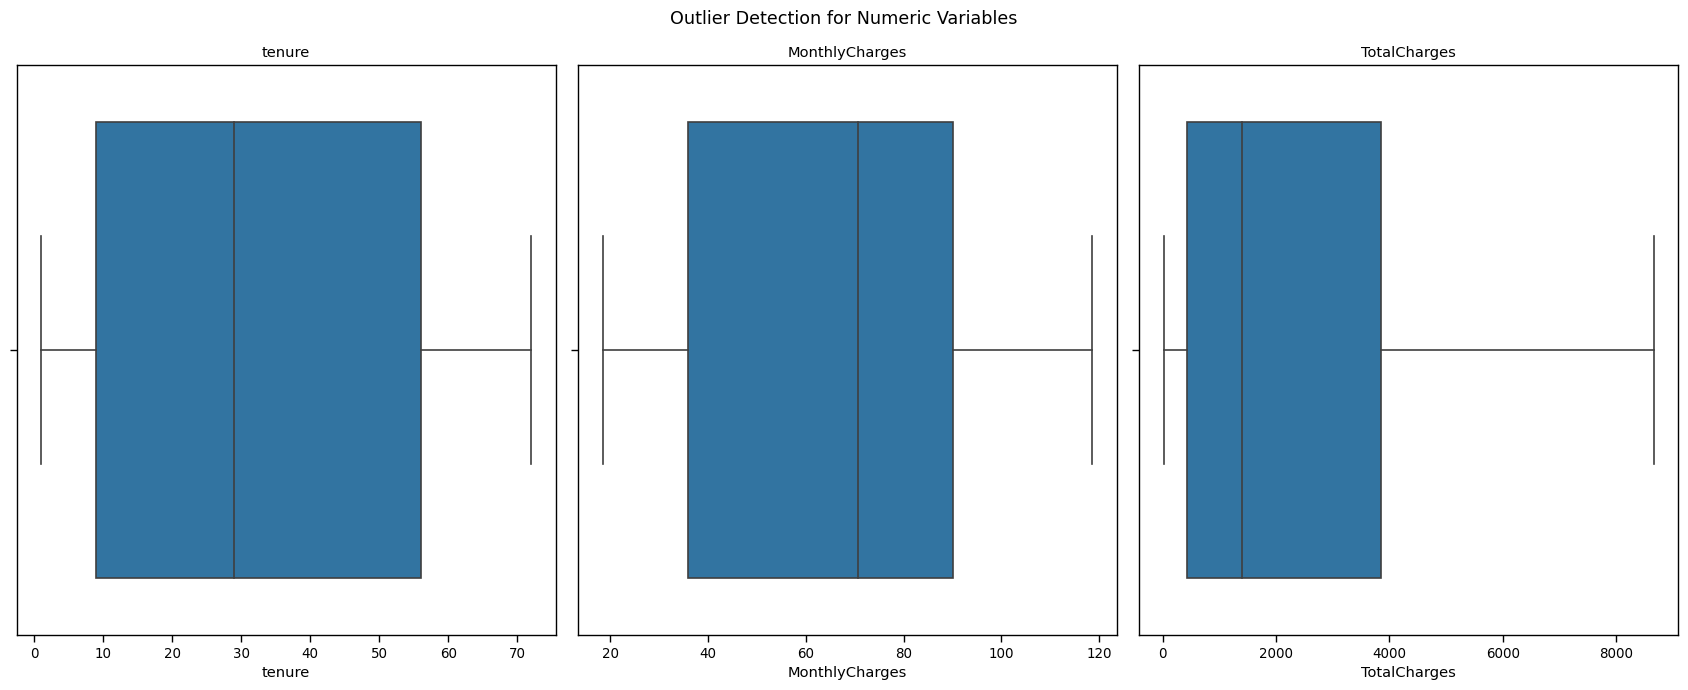

In [418]:
# plotting box plot to visualize outliers
fig, axes = plt.subplots(ncols = len(num_cols), figsize=(17,7))

for i, col in enumerate(num_cols):
    if data[col].dtype in ['int64', 'float64']:
        sns.boxplot(x=data[col], ax=axes[i])
        axes[i].set_title(col)
    else:
        axes[i].axis('off')

title = fig.suptitle('Outlier Detection for Numeric Variables')
plt.tight_layout()
plt.show()

**Inference**
- Our numerical columns are within range, as no outliers can be seen.

**Save cleaned dataset for other tasks**

In [419]:
#data.to_csv('data/complete.csv',index=False)

### <center>**Exploratory Data Analysis (EDA)**</center>

EDA is an essential and crucial initial step in the data analysis process, where the main objective is to gain insights and understanding of the dataset before performing any formal statistical modeling or making inferences.

In [420]:
data = pd.read_csv("../Data/complete.csv")

# Transform column titles to lowercase
for column in data.columns:
    data.rename(columns={column: column.lower()}, inplace=True)

In [421]:
for col in data.columns: 
    if data[col].dtype == object:
        print(f"{col}: {data[col].unique()}")

gender: ['Female' 'Male']
seniorcitizen: ['No' 'Yes']
partner: ['Yes' 'No']
dependents: ['No' 'Yes']
phoneservice: ['No' 'Yes']
multiplelines: ['No phone service' 'No' 'Yes']
internetservice: ['DSL' 'Fiber optic' 'No']
onlinesecurity: ['No' 'Yes' 'No internet service']
onlinebackup: ['Yes' 'No' 'No internet service']
deviceprotection: ['No' 'Yes' 'No internet service']
techsupport: ['No' 'Yes' 'No internet service']
streamingtv: ['No' 'Yes' 'No internet service']
streamingmovies: ['No' 'Yes' 'No internet service']
contract: ['Month-to-month' 'One year' 'Two year']
paperlessbilling: ['Yes' 'No']
paymentmethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
churn: ['No' 'Yes']


**How many people don't churn per Gender**

In [422]:
data.churn[data.churn == "No"].groupby(by = data.gender).count()

gender
Female    1823
Male      1883
Name: churn, dtype: int64

In [423]:
data.churn[data.churn == "Yes"].groupby(by = data.gender).count()

gender
Female    661
Male      675
Name: churn, dtype: int64

#### **Churn Distribution Gender**

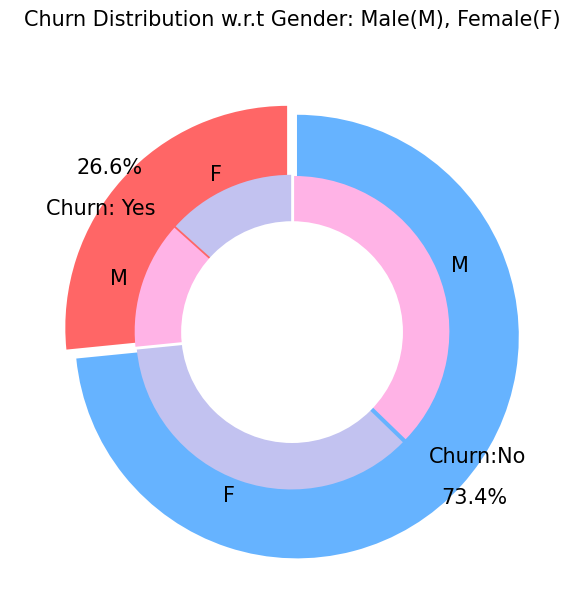

In [424]:
plt.figure(figsize=(6, 6))
labels =["Churn: Yes","Churn:No"]
values = [1869,5163]
labels_gender = ["F","M","F","M"]
sizes_gender = [939,930 , 2544,2619]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Churn Distribution w.r.t Gender: Male(M), Female(F)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

#### **Churn Distribution on Internet Service**

In [425]:
data[data["gender"]=="Male"][["internetservice", "churn"]].value_counts()

internetservice  churn
DSL              No       708
Fiber optic      No       651
No               No       524
Fiber optic      Yes      464
DSL              Yes      173
No               Yes       38
Name: count, dtype: int64

#### **Churn Distribution with Senior Citizen**

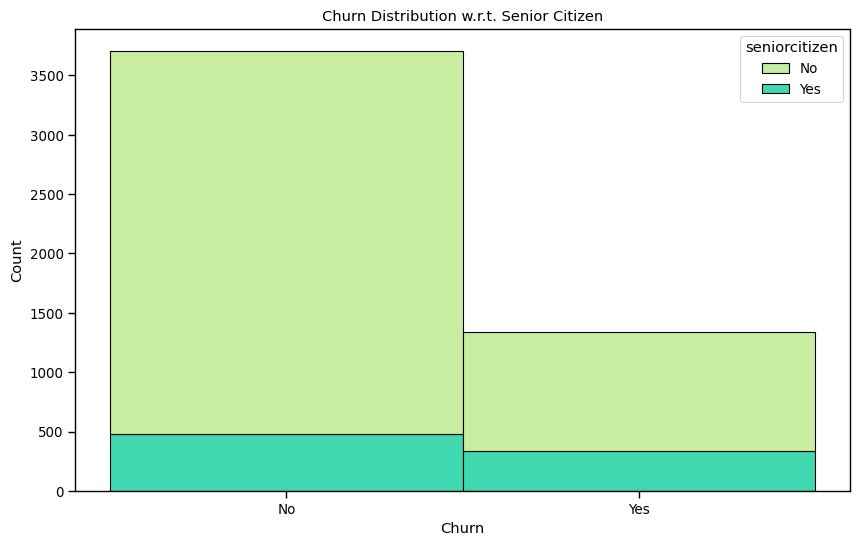

In [426]:
# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Create a histogram using seaborn
color_map = {'Yes': '#00CC96', 'No': '#B6E880'}
sns.histplot(data, x='churn', hue='seniorcitizen', multiple='stack', palette=color_map)

# Set the title and labels
plt.title('Churn Distribution w.r.t. Senior Citizen')
plt.xlabel('Churn')
plt.ylabel('Count')

# Show the plot
plt.show()


#### **Churn Distribution with Paperless Billing**

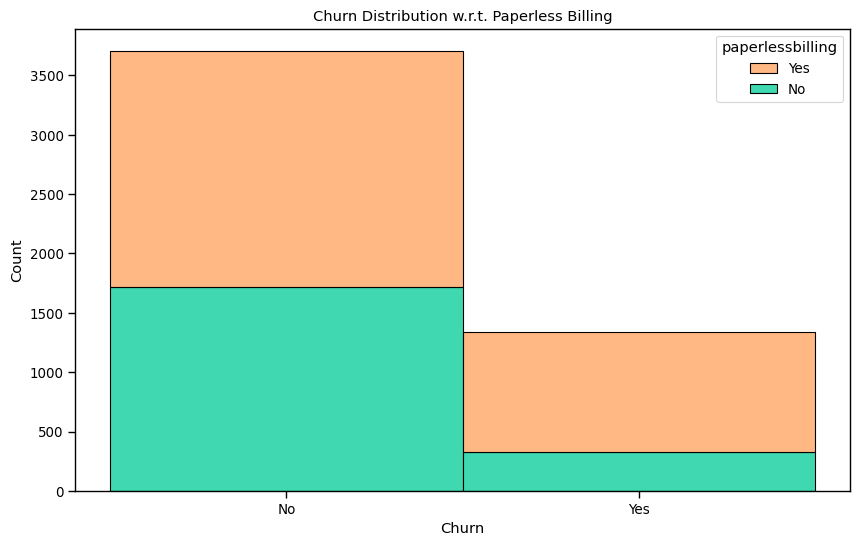

In [427]:
# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Create a histogram using seaborn
color_map = {'Yes': '#FFA15A', 'No': '#00CC96'}
sns.histplot(data, x='churn', hue='paperlessbilling', multiple='stack', palette=color_map)

# Set the title and labels
plt.title('Churn Distribution w.r.t. Paperless Billing')
plt.xlabel('Churn')
plt.ylabel('Count')

# Show the plot
plt.show()

#### **Churn Distribution with Phone Service**

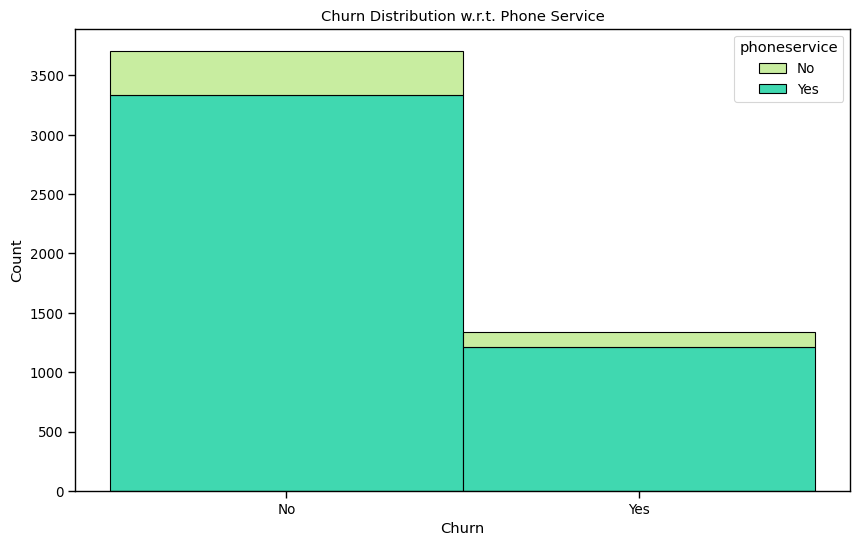

In [428]:
# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Create a histogram using seaborn
color_map = {'Yes': '#00CC96', 'No': '#B6E880'}
sns.histplot(data, x='churn', hue='phoneservice', multiple='stack', palette=color_map)

# Set the title and labels
plt.title('Churn Distribution w.r.t. Phone Service')
plt.xlabel('Churn')
plt.ylabel('Count')

# Show the plot
plt.show()

#### **Distribution of monthly charges by churn**

C:\Users\Hp\AppData\Local\Temp\ipykernel_9676\2557824474.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=Yes`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data.monthlycharges[(data["churn"] == 'No') ],
C:\Users\Hp\AppData\Local\Temp\ipykernel_9676\2557824474.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=Yes`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data.monthlycharges[(data["churn"] == 'Yes') ],


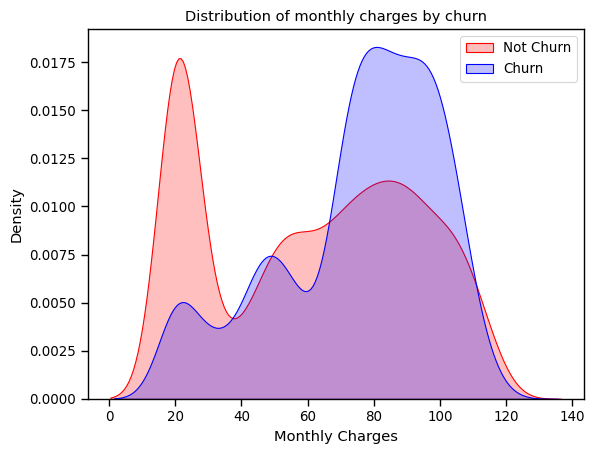

In [429]:
sns.set_context("paper",font_scale=1.1)
ax = sns.kdeplot(data.monthlycharges[(data["churn"] == 'No') ],
                color="Red", shade = 'Yes');
ax = sns.kdeplot(data.monthlycharges[(data["churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= 'Yes');
ax.legend(["Not Churn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Monthly Charges');
ax.set_title('Distribution of monthly charges by churn');

#### **Distribution of total charges by churn**

C:\Users\Hp\AppData\Local\Temp\ipykernel_9676\145476093.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=Yes`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data.totalcharges[(data["churn"] == "No") ],
C:\Users\Hp\AppData\Local\Temp\ipykernel_9676\145476093.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=Yes`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data.totalcharges[(data["churn"] == "Yes") ],


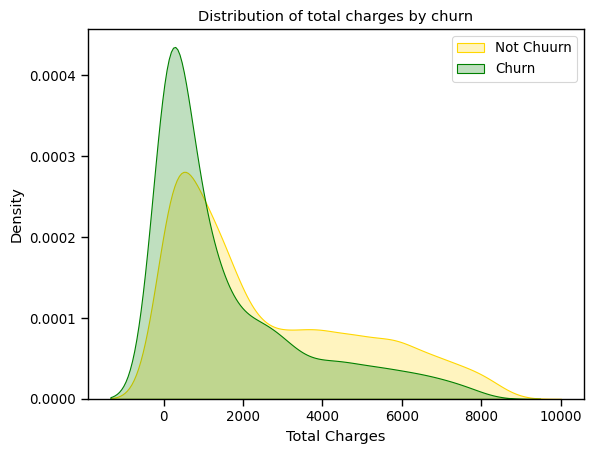

In [430]:
ax = sns.kdeplot(data.totalcharges[(data["churn"] == "No") ],
                color="Gold", shade = "Yes");
ax = sns.kdeplot(data.totalcharges[(data["churn"] == "Yes") ],
                ax =ax, color="Green", shade= "Yes");
ax.legend(["Not Chuurn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Total Charges');
ax.set_title('Distribution of total charges by churn');

#### **Tenure vs Churn**

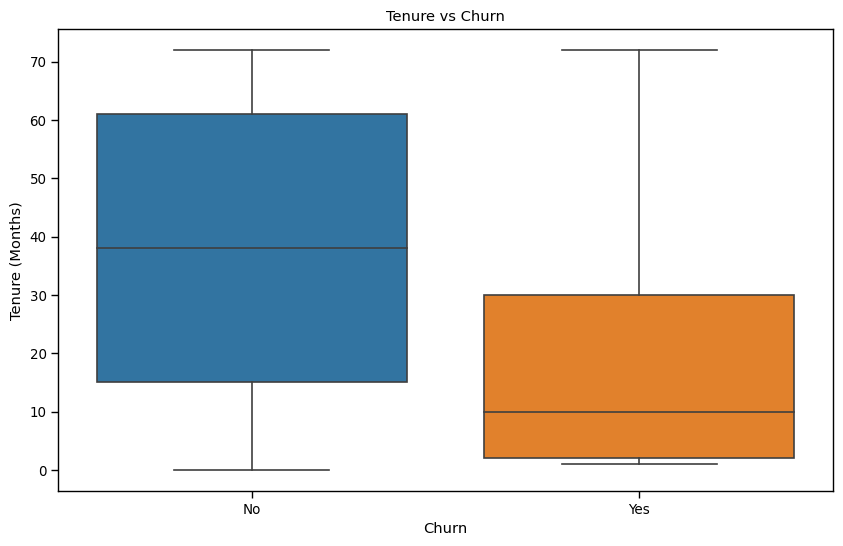

In [431]:
# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Create a boxplot using seaborn
sns.boxplot(x='churn', y='tenure', data=data)

# Set the title and labels
plt.title('Tenure vs Churn')
plt.xlabel('Churn')
plt.ylabel('Tenure (Months)')

# Show the plot
plt.show()


**Inferences**
- New customers are more likely to churn

### **Data Preprocessing and Variable Selection**

### Data transformation

- Encoding categorical variables: Convert categorical variables into numerical representations
- Scaling/Normalization: Scale features to similar ranges to avoid biases in certain algorithms

#### Identify Numerical and Categorical Variable

In [432]:
cat_cols = []
num_cols = []

for column in data.columns: 
    if data[column].dtype == 'object':
            cat_cols.append(column)
    else:
        num_cols.append(column)

print("Categorical values:\n", cat_cols)
print("\nNumerical values:\n", num_cols)

Categorical values:
 ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'churn']

Numerical values:
 ['tenure', 'monthlycharges', 'totalcharges']


### **Splitting the data to Train and Test sets**

#### Data splitting and feature-target separation


In [433]:
# partion features and target 
X=data.drop("churn",axis=1)
y= data["churn"]

# train test split
X_train, X_val, y_train, y_val= train_test_split(X, y,test_size=0.2, random_state =42)

In [434]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(4033, 19)
(4033,)
(1009, 19)
(1009,)


### **Encoding Categorical Variables**

We are going divide categorial columns into two parts:
- columns that need One-hot-Encoding
- columns that need Label encoding

In [435]:
# categorical variables that need One-hot-Encoding
cat_cols_ohe = ["internetservice", "contract", "paymentmethod"]

# categorical variables that needs Label-encoding
cat_cols_le = list(set(X_train.columns) - set(num_cols) - set(cat_cols_ohe))

print(cat_cols_ohe)
print(cat_cols_le)

['internetservice', 'contract', 'paymentmethod']
['multiplelines', 'paperlessbilling', 'dependents', 'partner', 'onlinebackup', 'gender', 'streamingtv', 'phoneservice', 'techsupport', 'onlinesecurity', 'deviceprotection', 'streamingmovies', 'seniorcitizen']


The function first handles columns with three values (like 'No phone service') and then applies label encoding to all the categorical columns

In [436]:

def labelEncode_categorical_columns(df, categorical_columns):
    for col in categorical_columns:
        if len(df[col].unique()) > 2:
            df[col] = df[col].apply(lambda x: 'No' if x.startswith('No') else x)

    label_encoder = LabelEncoder()
    for col in categorical_columns:
        df[col] = label_encoder.fit_transform(df[col])
    
    return df

#### Actual Encoding

In [437]:
X_train = labelEncode_categorical_columns(X_train, cat_cols_le)
X_val = labelEncode_categorical_columns(X_val, cat_cols_le)
X_train.head(3)

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
463,1,0,0,0,7,1,1,Fiber optic,0,1,0,0,1,1,Month-to-month,1,Electronic check,99.80,673.25
3688,1,0,0,0,5,1,0,Fiber optic,0,1,0,0,0,0,Month-to-month,1,Electronic check,74.65,383.65
1270,1,0,1,1,63,1,1,No,0,0,0,0,0,0,Two year,0,Credit card (automatic),24.65,1574.50


##### **Label Encoding Target Variable**

In [438]:
label_encoder = LabelEncoder()
y_train = pd.Series(label_encoder.fit_transform(y_train))
y_val = pd.Series(label_encoder.fit_transform(y_val))

verification:

In [439]:
print("label encoded feature variables: \n")
for col in cat_cols_le:
     print(X_train[col].unique())

print("\nlabel encoded target variable: \n")
print(y_train[:5])


label encoded feature variables: 

[1 0]
[1 0]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[1 0]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]

label encoded target variable: 

0    1
1    0
2    0
3    0
4    0
dtype: int32


#### **One-Hot-Encoding**

 The function iterates through the specified categorical columns, applies one-hot encoding, and then drops the original categorical columns

In [440]:
def one_hot_encode_columns(df, categorical_columns):
    for col in categorical_columns:
        encoded_cols = pd.get_dummies(df[col], prefix=f"{col}_category")
        encoded_cols = encoded_cols.astype(int)
        df = pd.concat([df, encoded_cols], axis=1)
    
    df = df.drop(columns=categorical_columns)
    return df

In [441]:
X_train = one_hot_encode_columns(X_train, cat_cols_ohe)
X_val = one_hot_encode_columns(X_val, cat_cols_ohe)

### **Feature Scaling/Nomalization**

Let first verifty the distribution of numberical variables

In [442]:
from sklearn.preprocessing import StandardScaler

In [443]:
def plotDistribution(column, dataframe, color='r'):
    plt.figure(figsize = (8,3))
    plt.title("Distribution of {}".format(column))
    ax = sns.histplot(dataframe[column], color=color)

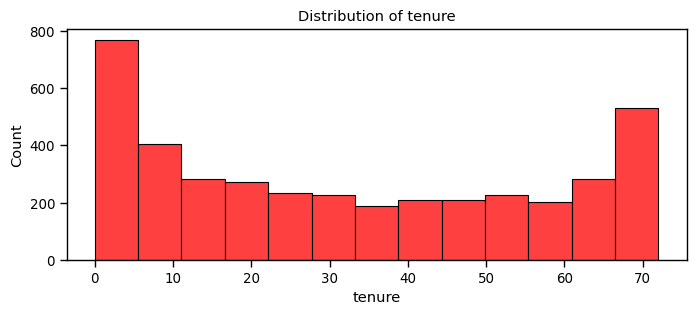

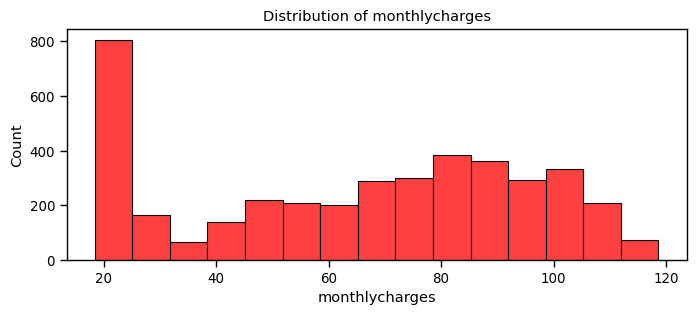

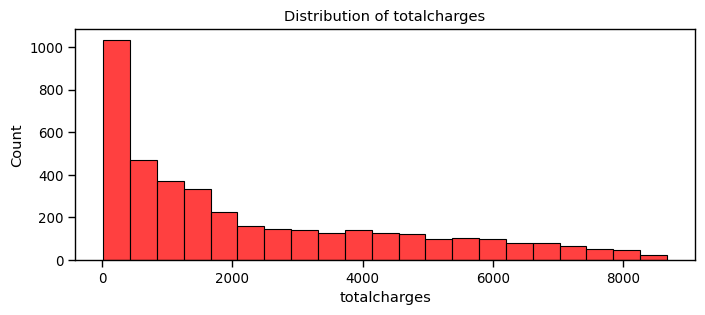

In [444]:
for col in num_cols: 
    plotDistribution(col, X_train)

In [445]:
def scale_numerical_columns(df, numerical_columns):
    standard_scaler = StandardScaler()
    scaled_data = standard_scaler.fit_transform(df[numerical_columns])
    scaled_df = pd.DataFrame(scaled_data, columns=numerical_columns)
    return scaled_df

In [446]:
scaled_df = scale_numerical_columns(X_train, num_cols)
scaled_df_ = scale_numerical_columns(X_val, num_cols)

#### Verification,

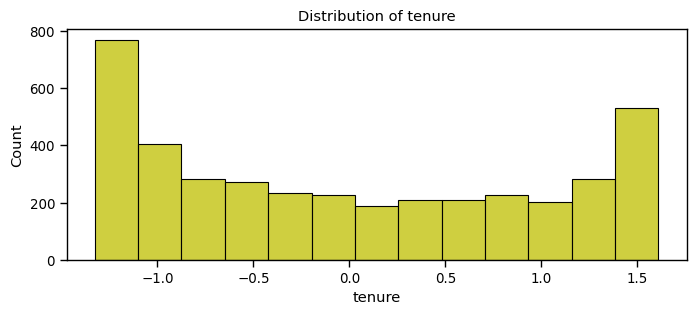

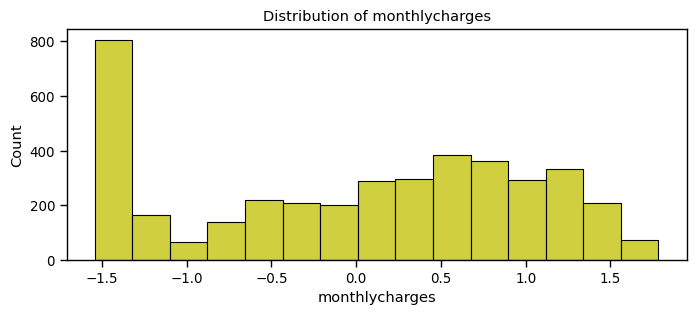

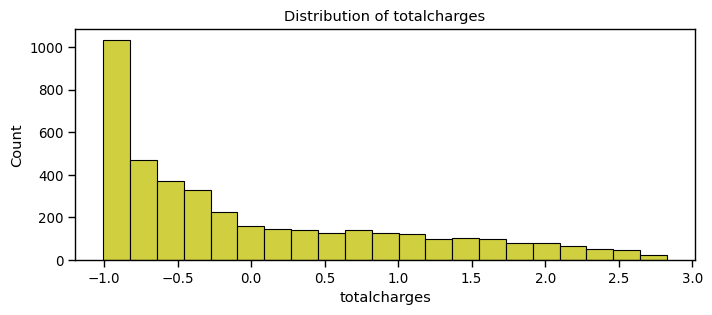

In [447]:
for column in num_cols: 
    plotDistribution(column, scaled_df, 'y')

### **Feature Selection**

To perform feature selection, we're going to use Variance Inflation Factor (VIF), which is a statistical measure used to assess multicollinearity among predictor variables in a regression model. 

In [448]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # Calculate initial VIF values
# vif_data = pd.DataFrame()
# vif_data["feature"] = X_train.columns
# vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]

# # Set the VIF threshold
# threshold = 7.5

# # Identify features with high VIF
# features_with_high_vif = vif_data[vif_data["VIF"] > threshold]["feature"]

# # Print features to drop
# features_to_drop = []
# for feature in features_with_high_vif:
#     if feature != "revenue_per_tenure":
#         features_to_drop.append(feature)

# #X_train = X_train.drop(columns=features_to_drop)

# features_to_drop


### **Multicollinearity**

**Investigating correlated independent variables**


In [449]:
#Pairs of highly correlated independent variables
df = X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df['pairs'] = list(zip(df.level_0, df.level_1))

df.set_index(['pairs'], inplace = True)
df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df.columns = ['cc']

df.drop_duplicates(inplace=True)

df[(df.cc>.75) & (df.cc<1)]

,cc
pairs,
"(tenure, totalcharges)",0.822479
"(internetservice_category_Fiber optic, monthlycharges)",0.790414
"(internetservice_category_No, monthlycharges)",0.762456


In [450]:
features_to_drop = ["totalcharges", "internetservice_category_Fiber optic", "internetservice_category_No"]
X_train = X_train.drop(columns=features_to_drop)

re-check

In [451]:
#Pairs of highly correlated independent variables
df = X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df['pairs'] = list(zip(df.level_0, df.level_1))

df.set_index(['pairs'], inplace = True)
df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df.columns = ['cc']

df.drop_duplicates(inplace=True)

df[(df.cc>.75) & (df.cc<1)]

,cc
pairs,


### **Data Balancing**

check and handle data imbalance

In [452]:
y_train.value_counts()

0    2947
1    1086
Name: count, dtype: int64

**Inference**
- our dataset possess data imbalance

**decision**
- Apply SMOTE to create synthetic samples

In [453]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

verify

In [454]:
y_train_resampled.value_counts()


1    2947
0    2947
Name: count, dtype: int64

In [455]:
X_val = X_val[X_train_resampled.columns]

### **Model Training**

**model selection**

For this we shall explore the following algorithms:

- Logistic Regression
- Random Forest
- K- Nearest Neighbour
- Support Vector Machine
- Gradient Boosting Classifier


**Baseline Model**

In [456]:
logistic_model=LogisticRegression()
logistic_model.fit(X_train_resampled,y_train_resampled)
y_predicted_logistic=logistic_model.predict(X_val)

c:\Users\Hp\AppData\Local\conda\conda\envs\robert\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Base Evaluation using a Confusion Matrix**

In [457]:
def evaluate_model_cm(model, val, predicted):
    # Calculate the confusion matrix and display it
    cm = metrics.confusion_matrix(val, predicted, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(f'Confusion Matrix for {model}')
    plt.grid(False)
    plt.show()

    # Calculate the scores
    scores = {
        'Accuracy': accuracy_score(val, predicted),
        'Recall': recall_score(val, predicted),
        'Precision': precision_score(val, predicted),
        'F1-Score': f1_score(val, predicted),
        'ROC AUC': roc_auc_score(val, predicted)
    }

    # Create a DataFrame from the scores
    scores_df = pd.DataFrame.from_dict(scores, orient='index', columns=['Score'])

    # Display the DataFrame
    
    return scores_df

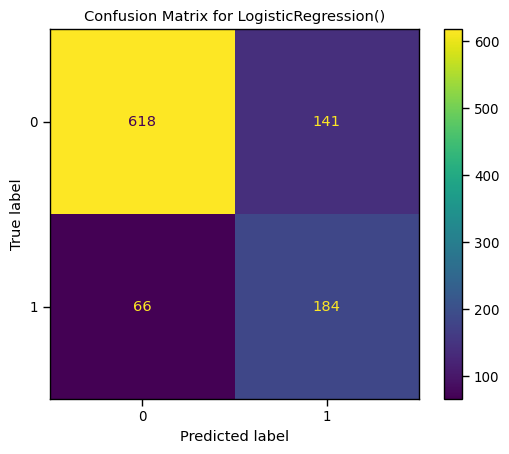

,Score
Accuracy,0.794846
Recall,0.736000
Precision,0.566154
F1-Score,0.640000
ROC AUC,0.775115


In [458]:
# Assuming y_val and y_predicted_logistic are 1-dimensional arrays or lists
evaluate_model_cm(logistic_model, y_val, y_predicted_logistic)

#### **Inferences:**

- In summary, the model has a decent accuracy and ROC AUC score, suggesting that it is able to classify instances reasonably well. However, there is a trade-off between precision and recall, with precision being relatively lower than recall, indicating that the model might generate some false positive

In [459]:
def score(model, x_train, y_train, x_val, y_val):
    # Calculate training and testing scores
    train_score = model.score(x_train, y_train)
    test_score = model.score(x_val, y_val)
    
    # Print the scores
    print(f"Train score: {train_score:.4f}\nTest score: {test_score:.4f}")


In [460]:
score(logistic_model,X_train_resampled,y_train_resampled,X_val,y_val)

Train score: 0.8339
Test score: 0.7948


**Inferences** 



The train score is 83% and that of test is 77%.

Since Both train and test scores exhibited no significant differences,
we conclude there is neither underfitting nor overfitting.


### **Random Forest**

In [461]:
#Instantiate a pipeline
pipeline3=Pipeline([('RF', RandomForestClassifier())])

rf_param_grid = {
    'RF__n_estimators': [10, 50, 100],
    'RF__criterion': ['gini', 'entropy'],
    'RF__max_depth': [None, 2, 6, 10],
    'RF__min_samples_split': [5, 10],
    'RF__min_samples_leaf': [3, 6]
}

rf_grid_search = GridSearchCV(pipeline3, rf_param_grid, cv=3)
rf_grid_search.fit(X_train_resampled, y_train_resampled)

# Print the test and train score
score(rf_grid_search,X_train_resampled, y_train_resampled,X_val,y_val)



Train score: 0.9145
Test score: 0.7919


#### **Inferences:**
- the model seems to have a higher accuracy on the training dataset compared to the test dataset. This could be an indication of overfitting, where the model performs very well on the training data but doesn't generalize as well to new, unseen data
- ``It's important to assess the degree of overfitting, consider potential model complexity, and explore methods to improve generalization to unseen data.``

### List of Models Intended to be used for Classification Tasks

In [462]:
models = []

models.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state = 0, class_weight='balanced')))
models.append(('Random Forest', RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state = 0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
models.append(('SVC', SVC(kernel = 'linear', random_state = 0)))
models.append(("Gradient boost classifier", GradientBoostingClassifier()))

### Evaluating all the models using K-Fold Cross-validation 

This code performs k-fold cross-validation for a list of classification models and computes evaluation metrics (ROC AUC and accuracy) for each model. It then stores the results in a Pandas DataFrame named model_results and sorts the results based on the mean ROC AUC values in descending order.

## **First Iteration**

In [463]:
# Create lists to store evaluation metrics for each model
accuracy_results = []
roc_auc_results = []
model_names = []

# Define the columns for the results DataFrame
result_columns = ["Algorithm", "Mean ROC AUC", "ROC AUC Std Dev", "Mean Accuracy", "Accuracy Std Dev"]
results_df = pd.DataFrame(columns=result_columns)

# Initialize index for the DataFrame
index = 0


# Perform k-fold cross-validation for each model
for model_name, model in models:
    model_names.append(model_name)
    kfold = KFold(n_splits=10)
    
    # Calculate cross-validation scores for ROC AUC and accuracy
    cv_roc_auc_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring="roc_auc")
    cv_accuracy_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy")
    
    # Append scores to respective result lists
    roc_auc_results.append(cv_roc_auc_scores)
    accuracy_results.append(cv_accuracy_scores)
    
    # Populate the results DataFrame
    results_df.loc[index] = [
        model_name,
        round(cv_roc_auc_scores.mean() * 100, 2),
        round(cv_roc_auc_scores.std() * 100, 2),
        round(cv_accuracy_scores.mean() * 100, 2),
        round(cv_accuracy_scores.std() * 100, 2)
    ]
    
    # Increment the index
    index += 1

# Sort the results DataFrame by mean ROC AUC in descending order
results_df_sorted = results_df.sort_values(by='Mean ROC AUC', ascending=False)

# Display the sorted results
results_df_sorted


,Algorithm,Mean ROC AUC,ROC AUC Std Dev,Mean Accuracy,Accuracy Std Dev
4,Gradient boost classifier,84.56,2.47,79.87,1.62
0,Logistic Regression,84.52,2.21,74.91,2.52
3,SVC,84.02,2.18,79.99,2.04
1,Random Forest,81.59,2.67,77.29,1.72
2,KNN,77.63,2.37,76.05,1.85


#### **Inferences**

- based on the given metrics, the "Gradient Boost Classifier" seems to perform the best overall, followed closely by "Logistic Regression," "SVC," and "Random Forest." "KNN" has relatively lower performance compared to the other algorithms.
- It's important to consider both ROC AUC and accuracy together and also explore other factors like model complexity and interpretability before making a final decision on the choice of algorithm

## **Hyperparameter Tuning**

#### **Warning: Resource-Intensive Process**

Due to the hardware limitations of my computer (4GB RAM, i3 CPU), I have opted for manual hyperparameter tuning instead of the grid-search based approach. Grid-search involves computationally demanding operations that might exceed the capacity of my current setup, potentially leading to system slowdowns or crashes. 

While manual tuning might not explore the entire hyperparameter space as extensively as grid-search, it provides a more feasible way to fine-tune the model given the available resources. I will be carefully selecting specific hyperparameters to adjust based on my understanding of the problem and observations.

I appreciate your understanding and flexibility as I work to deliver the best possible results under these constraints.


a function that automates the visualization process for different models

In [464]:
def plot_accuracy_vs_parameter(parameter_range, accuracy_scores, title):
    fig = plt.figure(figsize=(15, 7))
    plt.plot(parameter_range, accuracy_scores, color='#ec838a')
    plt.ylabel('Range\n', horizontalalignment="center", fontstyle="normal", fontsize="large", fontfamily="sans-serif")
    plt.xlabel('Score\n', horizontalalignment="center", fontstyle="normal", fontsize="large", fontfamily="sans-serif")
    plt.title(title, horizontalalignment="center", fontstyle="normal", fontsize="22", fontfamily="sans-serif")
    plt.xticks(rotation=0, horizontalalignment="center")
    plt.yticks(rotation=0, horizontalalignment="right")
    plt.show()


### **Gradient Boost Classifier**

The Gradient Boost Classifier is likely a strong performer in your task and could be a good starting point for further optimization.

In [465]:
# Initialize an empty list to store accuracy scores
gb_accuracy_scores = []

# Define a range of values for the 'n_estimators' parameter
n_estimators_values = range(1, 100)

# Iterate over different values of 'n_estimators'
for n_estimators in n_estimators_values:
    # Create a GradientBoostingClassifier with the current 'n_estimators' value
    gb_classifier = GradientBoostingClassifier(n_estimators=n_estimators, random_state=1)
    
    # Train the classifier on the training data
    gb_classifier.fit(X_train_resampled, y_train_resampled)
    
    # Calculate the accuracy score on the validation data
    accuracy = gb_classifier.score(X_val, y_val)
    
    # Append the accuracy score to the list
    gb_accuracy_scores.append(accuracy)

# Display the accuracy scores for different values of 'n_estimators'
gb_accuracy_scores[:5]


[0.7740336967294351,
 0.7294350842418236,
 0.7284440039643211,
 0.736372646184341,
 0.736372646184341]

**Visualize Performance of Paramenters**

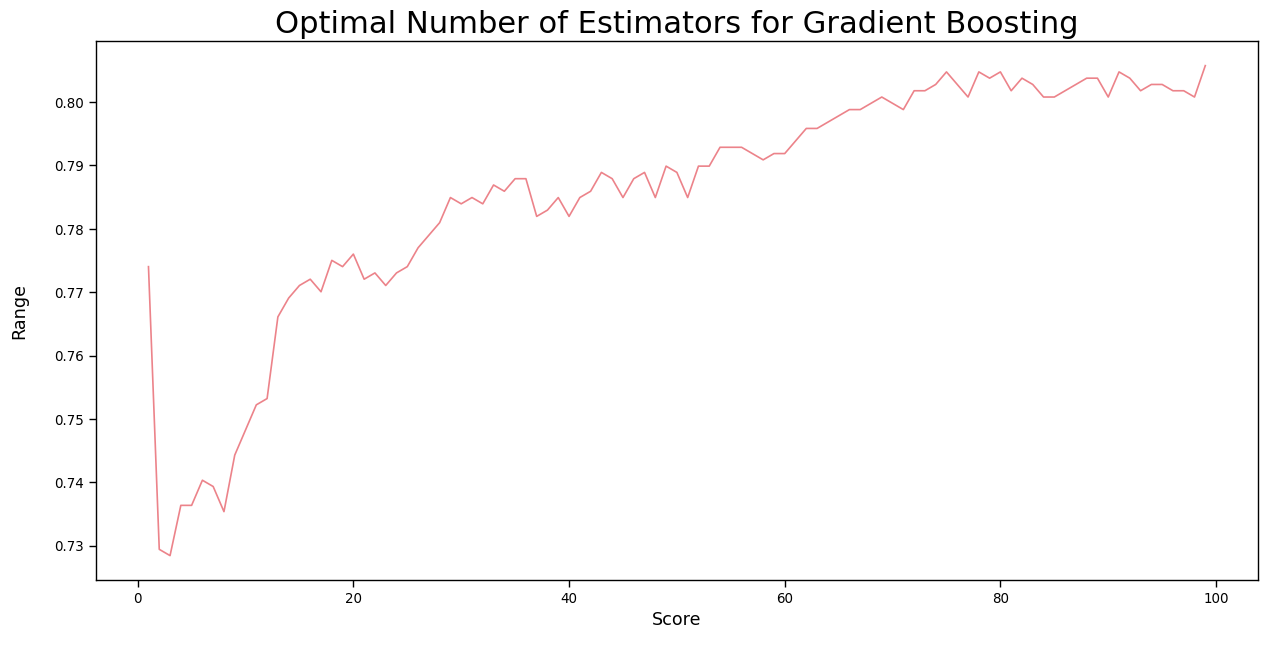

In [466]:
gb_n_estimators_values = range(1, 100)
#gb_accuracy_scores = [0.86, 0.88, 0.89, ...]  # Replace with your actual accuracy scores
gb_title = 'Optimal Number of Estimators for Gradient Boosting'
plot_accuracy_vs_parameter(gb_n_estimators_values, gb_accuracy_scores, gb_title)


### **Logistic Regression**

Despite having a lower accuracy compared to some other models, its ROC AUC score suggests it's effective at distinguishing between classes based on probabilities.

In [467]:

# Initialize an empty list to store accuracy scores
lr_accuracy_scores = []

# Define a range of values for the 'C' parameter
c_values = [0.01, 0.1, 1, 10, 100]

# Iterate over different values of 'C'
for c in c_values:
    # Create a LogisticRegression classifier with the current 'C' value
    lr_classifier = LogisticRegression(C=c, random_state=1)
    
    # Train the classifier on the training data
    lr_classifier.fit(X_train, y_train)
    
    # Calculate the accuracy score on the validation data
    accuracy = lr_classifier.score(X_val, y_val)
    
    # Append the accuracy score to the list
    lr_accuracy_scores.append(accuracy)

# Display the accuracy scores for different values of 'C'
lr_accuracy_scores

c:\Users\Hp\AppData\Local\conda\conda\envs\robert\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Hp\AppData\Local\conda\conda\envs\robert\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

[0.8206144697720515,
 0.8136769078295342,
 0.8107036669970268,
 0.8097125867195243,
 0.8107036669970268]

**Visualize Performance of Paramenters**

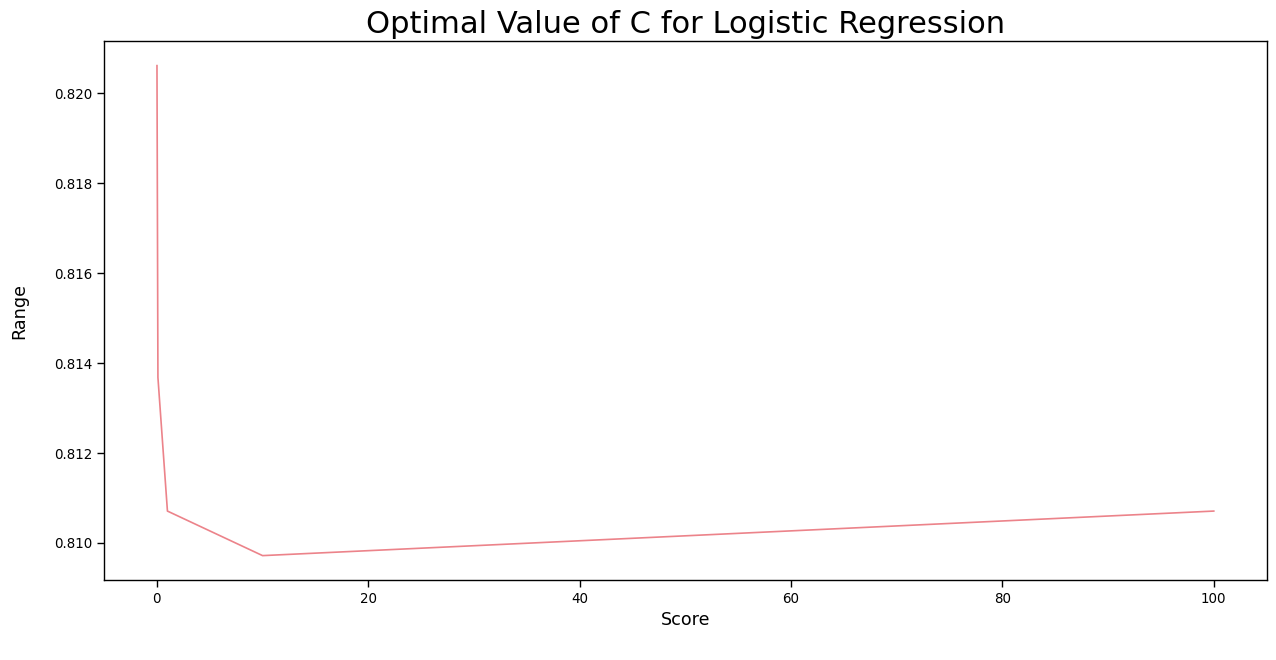

In [468]:
lr_c_values = [0.01, 0.1, 1, 10, 100]
lr_title = 'Optimal Value of C for Logistic Regression'
plot_accuracy_vs_parameter(lr_c_values, lr_accuracy_scores, lr_title)

### **SVC**

Its consistent performance (low standard deviations) indicates stability across different datasets or splits.

In [469]:
# Initialize an empty list to store accuracy scores
svc_accuracy_scores = []

# Define a range of values for the 'C' parameter
c_values = [0.01, 0.1, 1, 10, 100]

# Iterate over different values of 'C'
for c in c_values:
    # Create an SVC classifier with the current 'C' value
    svc_classifier = SVC(C=c, random_state=1)
    
    # Train the classifier on the training data
    svc_classifier.fit(X_train, y_train)
    
    # Calculate the accuracy score on the validation data
    accuracy = svc_classifier.score(X_val, y_val)
    
    # Append the accuracy score to the list
    svc_accuracy_scores.append(accuracy)

# Display the accuracy scores for different values of 'C'
svc_accuracy_scores

[0.7522299306243806,
 0.8116947472745293,
 0.8107036669970268,
 0.8126858275520317,
 0.8136769078295342]

**Visualize Performance of Paramenters**

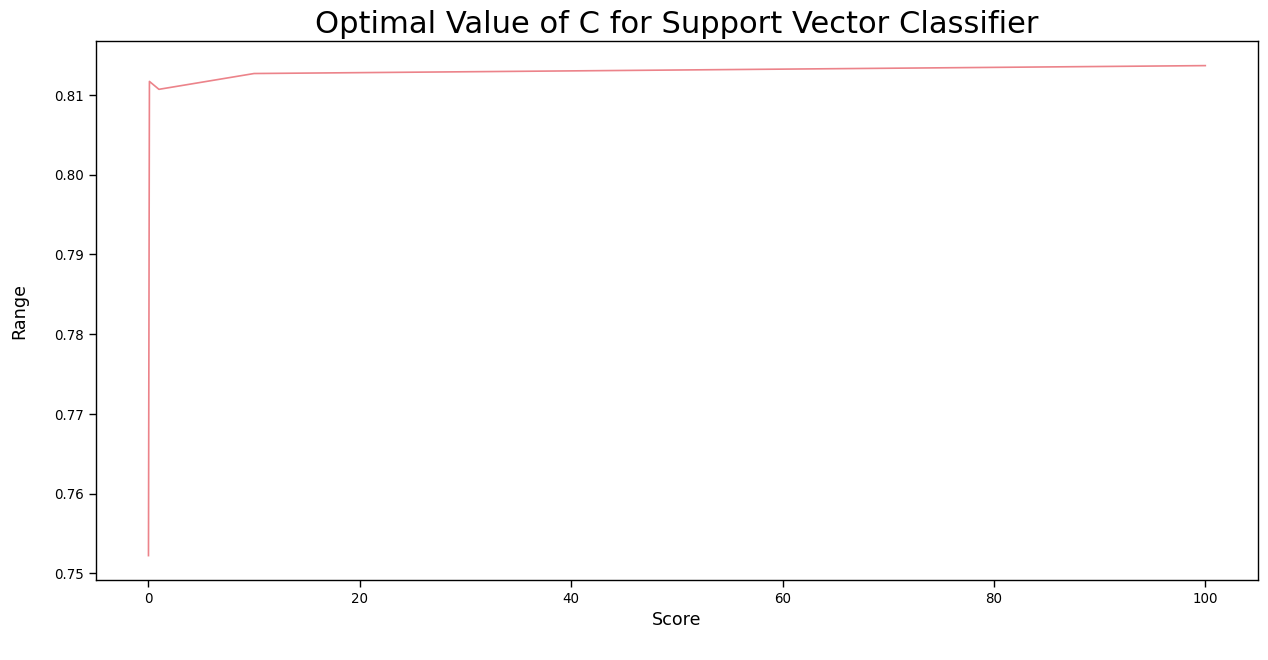

In [470]:
svc_c_values = [0.01, 0.1, 1, 10, 100]
svc_title = 'Optimal Value of C for Support Vector Classifier'
plot_accuracy_vs_parameter(svc_c_values, svc_accuracy_scores, svc_title)

### **KNN**

- It seems to perform adequately, but not as well as the top models in this comparison.
- KNN could potentially benefit from tuning its hyperparameters or exploring other algorithms.

In [471]:
# Initialize an empty list to store accuracy scores
knn_accuracy_scores = []

# Iterate over different values of n_neighbors
for n_neighbors in range(1, 25):
    # Create a KNeighborsClassifier with the current value of n_neighbors
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Train the classifier on the training data
    knn_classifier.fit(X_train, y_train)
    
    # Calculate the accuracy score on the test data
    accuracy = knn_classifier.score(X_val, y_val)
    
    # Append the accuracy score to the list
    knn_accuracy_scores.append(accuracy)

# Display the accuracy scores for different values of n_neighbors
knn_accuracy_scores[:10]

[0.736372646184341,
 0.7829534192269574,
 0.7750247770069376,
 0.7829534192269574,
 0.7680872150644202,
 0.7809712586719524,
 0.7710604558969276,
 0.7859266600594648,
 0.7789890981169475,
 0.7869177403369673]

**Visualize Performance of Paramenters**

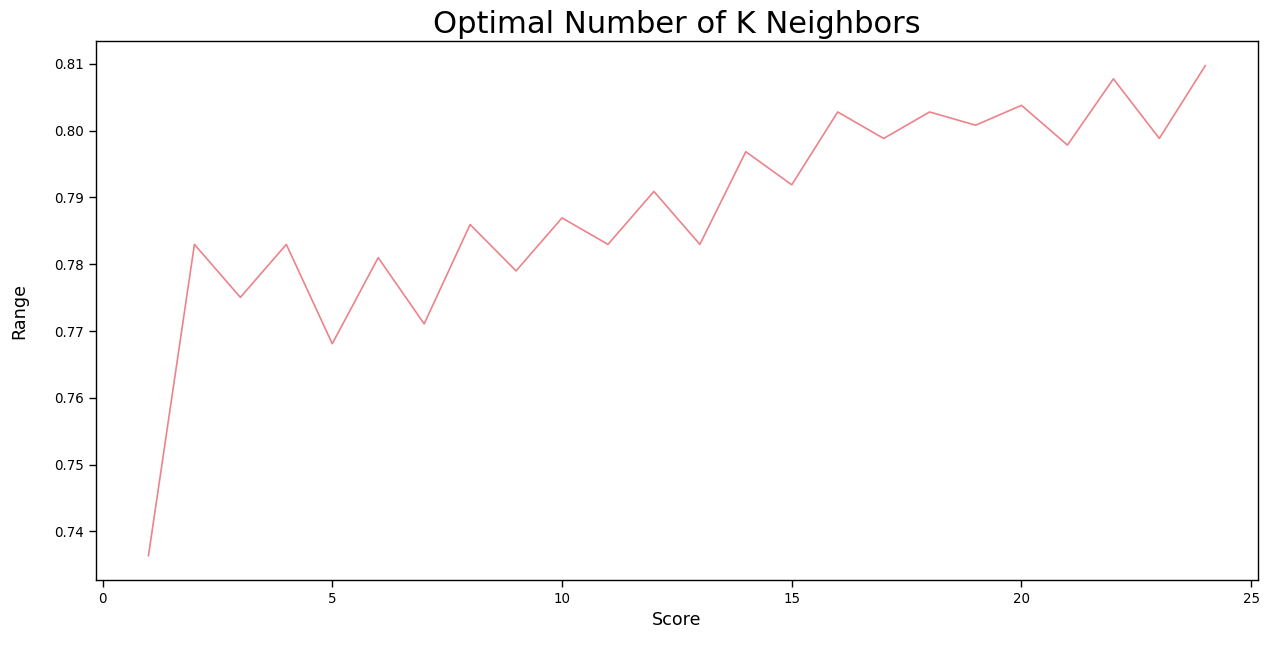

In [472]:
knn_parameter_range = range(1, 25)
#knn_accuracy_scores = [0.85, 0.88, 0.87, ...]  # Replace with your actual accuracy scores
knn_title = 'Optimal Number of K Neighbors'
plot_accuracy_vs_parameter(knn_parameter_range, knn_accuracy_scores, knn_title)


**Observations**
- bias-variance trade-off, the accuracy increases initially and then reach a peak(0.757) before starting to decrease(0.718)
- there's neither overfitting or underfitting since the trend range between 0.69 & 0.761

### **Random Forest**

- The Random Forest model has a mean ROC AUC of 72.64 and mean Accuracy of 72.29.
- While it's performing well, it's not the top performer in this comparison.
- If interpretability and ease of use are important, Random Forest might still be a good choice due to its ensemble nature.

In [473]:
# Initialize an empty list to store accuracy scores
rf_accuracy_scores = []

# Iterate over different values of n_estimators
for n_estimators in range(1, 100):
    # Create a RandomForestClassifier with the current value of n_estimators
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=1)
    
    # Train the classifier on the training data
    rf_classifier.fit(X_train, y_train)
    
    # Calculate the accuracy score on the test data
    accuracy = rf_classifier.score(X_val, y_val)
    
    # Append the accuracy score to the list
    rf_accuracy_scores.append(accuracy)

rf_accuracy_scores[:10]


[0.7433102081268583,
 0.7740336967294351,
 0.7631318136769079,
 0.77998017839445,
 0.77998017839445,
 0.7918731417244796,
 0.77998017839445,
 0.796828543111992,
 0.796828543111992,
 0.8017839444995044]

**Visualize Performance of Paramenters**

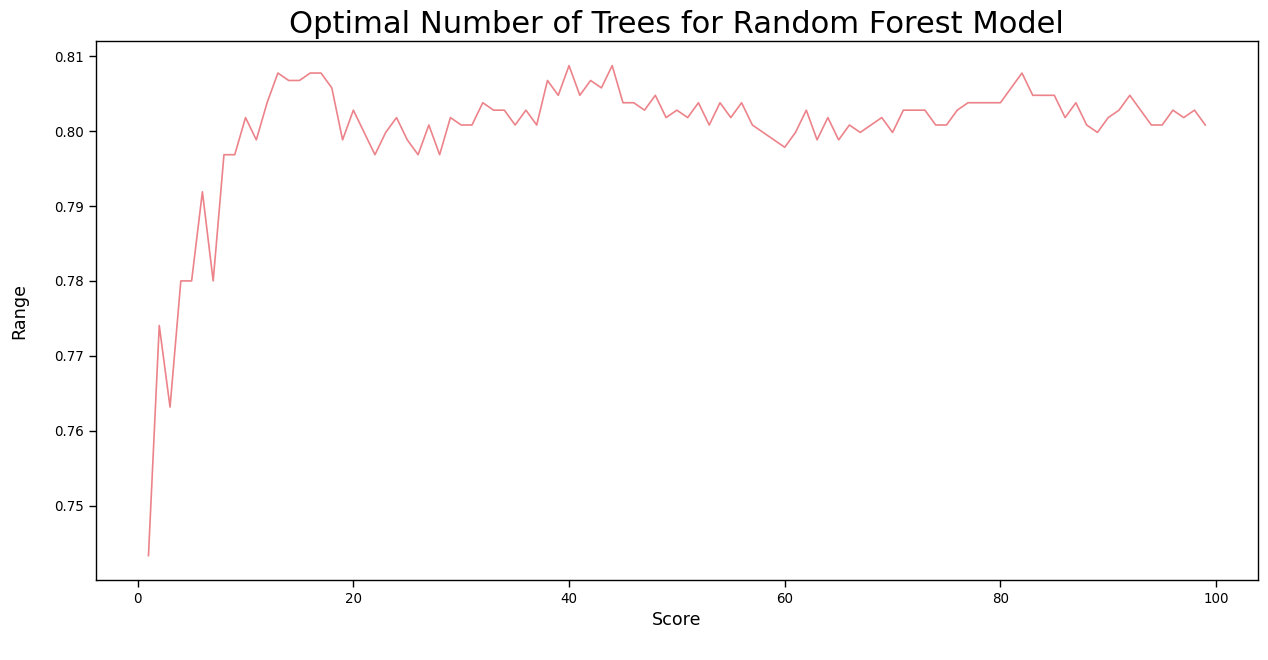

In [474]:
rf_parameter_range = range(1, 100)
rf_title = 'Optimal Number of Trees for Random Forest Model'
plot_accuracy_vs_parameter(rf_parameter_range, rf_accuracy_scores, rf_title)

## **Second Iteration**

In [475]:
def model_evaluation(y_test, y_pred, model_name):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2.0)
    
    # Create a DataFrame to store results
    results = pd.DataFrame(
        [[model_name, accuracy, precision, recall, f1, f2]],
        columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "F2 Score"]
    )
    
    # Sort results based on precision, recall, and F2 score in descending order
    results = results.sort_values(["Precision", "Recall", "F2 Score"], ascending=False)
    
    # Return the sorted results
    return results


### **Classifier Initialization and Training**

In [476]:
# Logistic Regression
logistic_classifier = LogisticRegression(random_state=0)
logistic_classifier.fit(X_train_resampled, y_train_resampled)
y_pred_logistic = logistic_classifier.predict(X_val)


# Support Vector Classifier (SVC)
svc_classifier = SVC(kernel='linear', random_state=0)
svc_classifier.fit(X_train_resampled, y_train_resampled)
y_pred_svc = svc_classifier.predict(X_val)


# Random Forest Classifier
random_forest_classifier = RandomForestClassifier(n_estimators=72, criterion='entropy', random_state=0)
random_forest_classifier.fit(X_train_resampled, y_train_resampled)
y_pred_random_forest = random_forest_classifier.predict(X_val)


# K-Nearest Neighbors (KNN)
knn_classifier = KNeighborsClassifier(n_neighbors=22, metric='minkowski', p=2)
knn_classifier.fit(X_train_resampled, y_train_resampled)
y_pred_knn = knn_classifier.predict(X_val)


# Gradient Boosting Classifier
gradient_boost_classifier = GradientBoostingClassifier()
gradient_boost_classifier.fit(X_train_resampled, y_train_resampled)
y_pred_gradient_boost = gradient_boost_classifier.predict(X_val)


c:\Users\Hp\AppData\Local\conda\conda\envs\robert\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### **Model Evaluation**

In [477]:
# Evaluate Logistic Regression model
lr_evaluation = model_evaluation(y_val, y_pred_logistic, "Logistic Regression")

# Evaluate Random Forest model
rf_evaluation = model_evaluation(y_val, y_pred_random_forest, "Random Forest")

# Evaluate Gradient Boosting model
gb_evaluation = model_evaluation(y_val, y_pred_gradient_boost, "Gradient Boost")

# Evaluate Support Vector Classifier (SVC) model
svc_evaluation = model_evaluation(y_val, y_pred_svc, "Support Vector Classifier")

# Evaluate K-Nearest Neighbours model
knn_evaluation = model_evaluation(y_val, y_pred_knn, "K-Nearest Neighbours")


### **Model Ranking**

In [478]:
# Combine evaluation results of different models into a single DataFrame
eval_ = pd.concat([lr_evaluation, rf_evaluation, gb_evaluation, svc_evaluation, knn_evaluation])

# Sort the DataFrame based on Precision, Recall, and F2 Score in descending order
eval_ = eval_.sort_values(by=["Precision", "Recall", "F2 Score"], ascending=False)

# Reset the index of the DataFrame and drop the previous index column
eval_ = eval_.reset_index(drop=True)

eval_


,Model,Accuracy,Precision,Recall,F1 Score,F2 Score
0,Gradient Boost,0.805748,0.584375,0.748,0.656140,0.708333
1,Logistic Regression,0.794846,0.566154,0.736,0.640000,0.694340
2,Support Vector Classifier,0.791873,0.563694,0.708,0.627660,0.673516
3,Random Forest,0.785927,0.562963,0.608,0.584615,0.598425
4,K-Nearest Neighbours,0.706640,0.448430,0.800,0.574713,0.691563


### **Visualization of Confusion Matrices for Different Models**

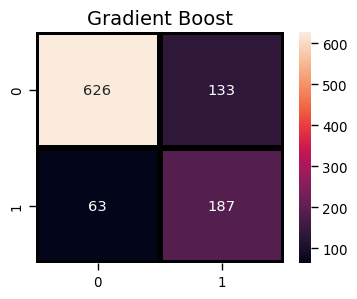

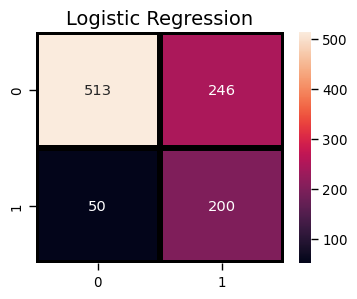

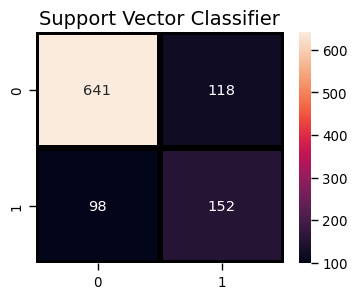

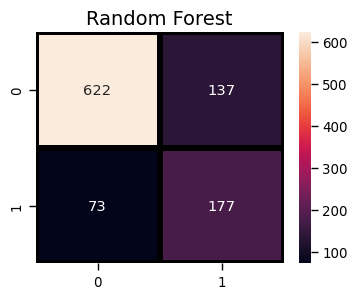

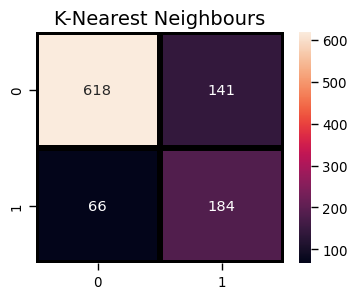

In [479]:
# List of predicted labels from different models
predictions = [y_pred_gradient_boost, y_pred_knn, y_pred_random_forest, y_pred_svc, y_pred_logistic]

# Iterate over pairs of predictions and model names
for pred, model_name in zip(predictions, eval_['Model'].values):
    plt.figure(figsize=(4, 3))
    sns.heatmap(confusion_matrix(y_val, pred), annot=True, fmt="d", linecolor="k", linewidths=3)
    plt.title(model_name, fontsize=14)
    plt.show()


**k-Fold Cross-Validation:**

The process of evaluating a model often involves using the 'K-fold Cross-Validation' technique, which is particularly effective in addressing variance issues. Variance problems arise when a model performs well on one test set but shows different accuracy when tested on another. To mitigate this variance problem, k-fold cross-validation divides the training set into 10 subsets, or "folds," where the model is trained on 9 folds and then tested on the remaining fold. This repeated process helps stabilize the performance assessment across multiple test subsets and contributes to more reliable model evaluation.

## **Third Iteration**

In [480]:
def k_fold_cross_validation(classifier, classifier_name):
    accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10)
    mean_accuracy = accuracies.mean()
    std_accuracy = accuracies.std() * 2
    print(f"{classifier_name} accuracy: {mean_accuracy:.2f} (+/- {std_accuracy:.2f})")


### **K-Fold Cross-Validation and Performance Assessment**

This is a method used to assess the generalization performance of a machine learning model by evaluating it on multiple subsets of the training data.

In [481]:
print(k_fold_cross_validation( gradient_boost_classifier, "Gradient Boost"))
print(k_fold_cross_validation( logistic_classifier, "Logistic regression"))
print(k_fold_cross_validation( svc_classifier, "Support Vector Classifier"))
print(k_fold_cross_validation( knn_classifier, "K-Nearest Neighbours"))
print(k_fold_cross_validation( random_forest_classifier, "Random Forest"))

Gradient Boost accuracy: 0.80 (+/- 0.04)
None


c:\Users\Hp\AppData\Local\conda\conda\envs\robert\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Hp\AppData\Local\conda\conda\envs\robert\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

Logistic regression accuracy: 0.80 (+/- 0.04)
None
Support Vector Classifier accuracy: 0.80 (+/- 0.04)
None
K-Nearest Neighbours accuracy: 0.78 (+/- 0.04)
None
Random Forest accuracy: 0.77 (+/- 0.04)
None


#### **Receiver Operating Characteristic (ROC) Curve Visualization**

This visualization helps to assess the classifier's performance in terms of the trade-off between true positive rate and false positive rate across different threshold settings

In [482]:
def ROC_curve(classifier_, name, y_pred_):
    classifier_.fit(X_train_resampled, y_train_resampled) 
    probs = classifier_.predict_proba(X_val) 
    probs = probs[:, 1] 
    classifier_roc_auc = roc_auc_score(y_val, probs )
    rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_val, classifier_.predict_proba(X_val)[:,1])
    plt.figure(figsize=(14, 6))

    label_ = name + '(area = %0.2f)' % classifier_roc_auc
    # Plot Adaboost ROC
    plt.plot(rf_fpr, rf_tpr, 
    label=label_)
    # Plot Base Rate ROC
    plt.plot([0,1], [0,1],label='Base Rate' 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.ylabel('True Positive Rate \n',horizontalalignment="center",
    fontstyle = "normal", fontsize = "medium", 
    fontfamily = "sans-serif")

    plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",
    fontstyle = "normal", fontsize = "medium", 
    fontfamily = "sans-serif")

    plt.title('ROC Graph \n',horizontalalignment="center", 
    fontstyle = "normal", fontsize = "22", 
    fontfamily = "sans-serif")

    plt.legend(loc="lower right", fontsize = "medium")
    plt.xticks(rotation=0, horizontalalignment="center")
    plt.yticks(rotation=0, horizontalalignment="right")
    plt.show()


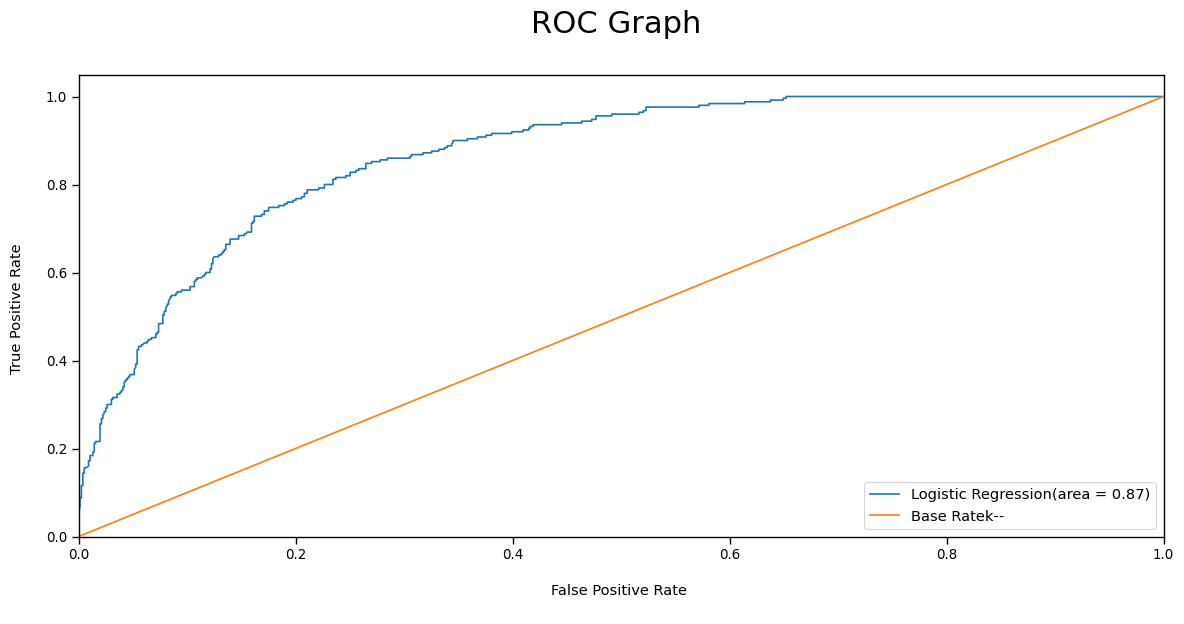

c:\Users\Hp\AppData\Local\conda\conda\envs\robert\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


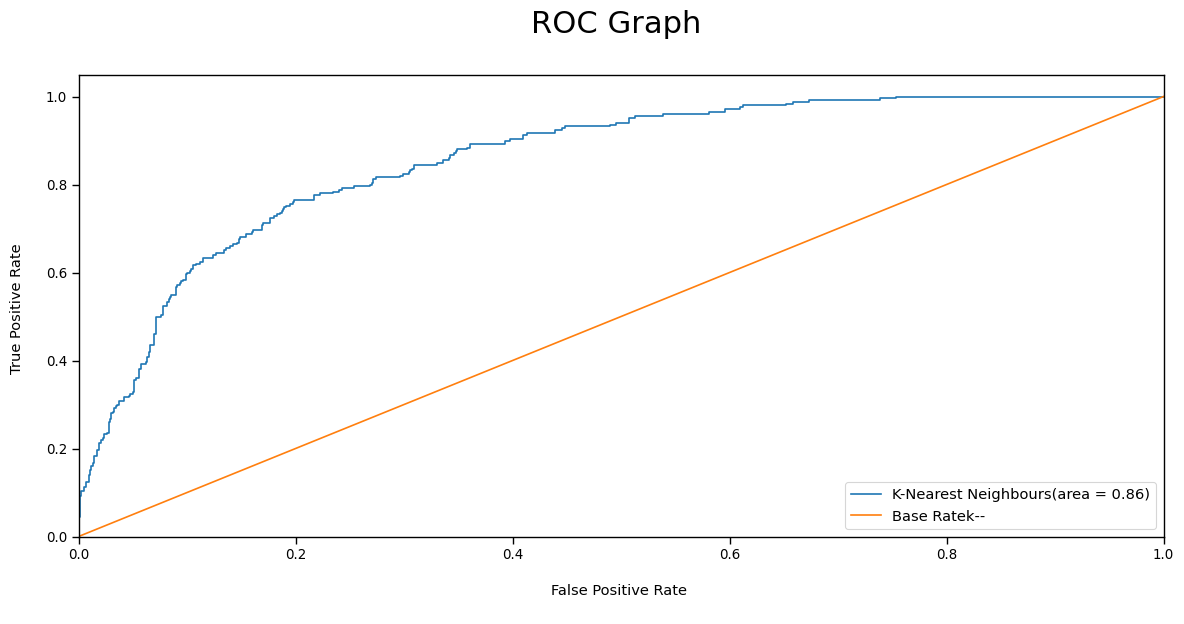

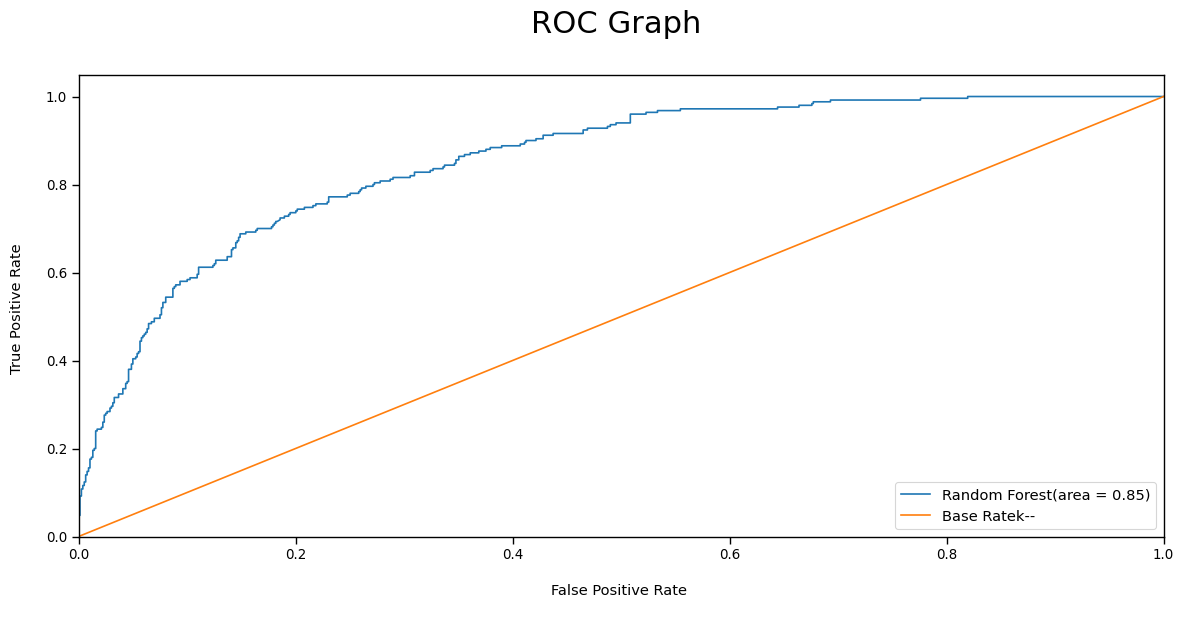

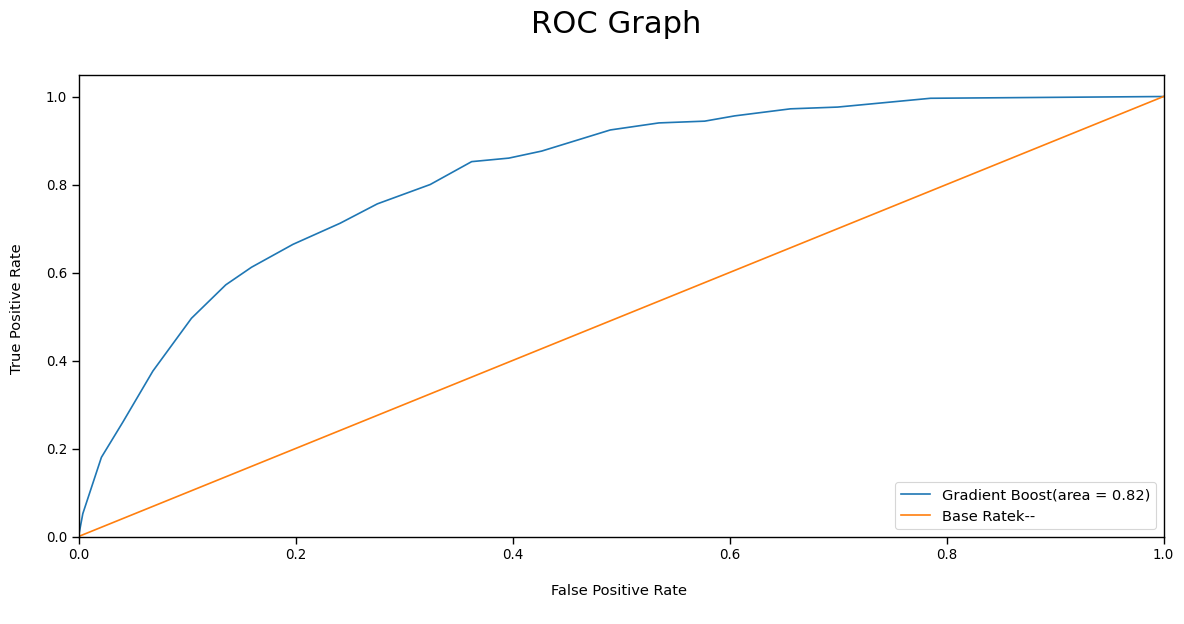

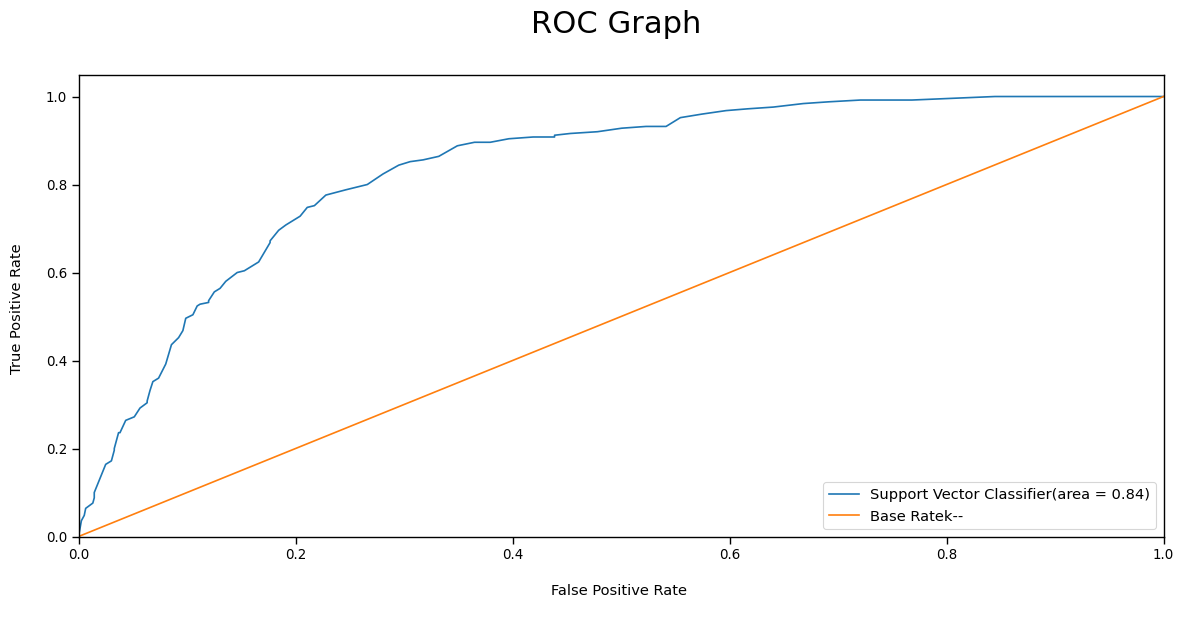

In [483]:
preds = [y_pred_logistic, y_pred_knn, y_pred_random_forest, y_pred_gradient_boost, y_pred_svc ]

classifiers = [gradient_boost_classifier, logistic_classifier, svc_classifier, knn_classifier,random_forest_classifier]

model_names_ = ["Logistic Regression", "K-Nearest Neighbours","Random Forest","Gradient Boost","Support Vector Classifier"]

for i, j, k in zip(classifiers, model_names_, preds):
    # Check if the classifier supports probability estimation
    if hasattr(i, 'probability') and not i.probability:
        i.probability = True
        
    ROC_curve(i, j, k)

**Inference**

- When the "model area" (ROC AUC score) is above the "base rate" line, it indicates that the classifier's performance is better than random guessing. In other words, the classifier has some level of discriminatory power and is capable of distinguishing between the two classes (positive and negative) better than a random classifier.

**Model area is above base rate (ROC AUC > 0.5)**
- If the ROC AUC score is greater than 0.5, it means that the classifier's performance is better than random guessing.
- The higher the ROC AUC score, the better the classifier's ability to correctly classify instances and discriminate between the classes.
- An ROC AUC of 1 indicates a perfect classifier.

### **Cross-validation on Classifiers**

comparing the performance of multiple classifiers using cross-validation

In [484]:
# Function that will track the mean value and the standard deviation of the accuracy
def cvDictGen(classifiers, scoring, X_train=X, y_train=y, cv=5):
    cv_dict = {}
    for classifier in classifiers:
        cv_scores = cross_val_score(classifier, X_train_resampled, y_train_resampled, cv=cv, scoring=scoring)
        classifier_name = str(classifier).split('(')[0]
        cv_dict[classifier_name] = [cv_scores.mean(), cv_scores.std()]
    
    return cv_dict

This function will It generate a dictionary that provides insight into how well each classifier is performing based on the specified scoring metric.

In [485]:
# cv_Dict = cvDictGen(classifiers, scoring = 'roc_auc')
# cv_Dict

### **Predicting Feature Importance   _______ (hypothesis-testing)**

In [486]:
# Gradient Boost
feature_importances = pd.concat([pd.DataFrame(X.columns, columns = ["features"]),
                                 pd.DataFrame(np.transpose(gradient_boost_classifier.feature_importances_), columns = ["coeficient"])],axis = 1)
                                 
print("\n--- Most Relevant Features ---")
feature_importances.sort_values(by = "coeficient", ascending = False).head(5)


--- Most Relevant Features ---


,features,coeficient
16,paymentmethod,0.301692
14,contract,0.141277
17,monthlycharges,0.115787
4,tenure,0.080624
18,totalcharges,0.064054


### **Further Hyper Parameter Tuning**

#### **Using Randomized search CV**

#### **Gradient Boost**

In [487]:
gb_HyperParams = {'loss' : ['deviance', 'exponential'],
                 'n_estimators': randint(10, 500),
                 'max_depth': randint(1,10)}
# Initialization
gridSearch_GB = RandomizedSearchCV(estimator =gradient_boost_classifier , param_distributions = gb_HyperParams, n_iter = 10, scoring = 'roc_auc')

# Fitting the model
gridSearch_GB.fit(X_train_resampled, y_train_resampled)

c:\Users\Hp\AppData\Local\conda\conda\envs\robert\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


c:\Users\Hp\AppData\Local\conda\conda\envs\robert\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\Hp\AppData\Local\conda\conda\envs\robert\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\Hp\AppData\Local\conda\conda\envs\robert\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\Hp\AppData\Local\conda\conda\envs\robert\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was dep

RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                   param_distributions={'loss': ['deviance', 'exponential'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000015E71642640>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000015E73F393A0>},
                   scoring='roc_auc')

**Get the Best model**

In [488]:
gridSearch_GB.best_params_, 
gridSearch_GB.best_score_

0.9264217609450383

In [489]:
best_GB_model_fitted_rs = gridSearch_GB.best_estimator_.fit(X_train_resampled, y_train_resampled)

In [490]:
# Getting the score AdaBoost
test_labels_GB_rs = best_GB_model_fitted_rs.predict_proba(np.array(X_val.values))[:,1]
roc_auc_score(y_val,test_labels_GB_rs , average = 'macro', sample_weight = None)

c:\Users\Hp\AppData\Local\conda\conda\envs\robert\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


0.8616469038208169

### **Using Grid SearchCV**

In [491]:
gb_param_grid = {'loss' : ['deviance'],
                 'n_estimators': [10,100,200,300],
                 'max_depth': [1,2,4,6,8]}

gs_GB = GridSearchCV(gradient_boost_classifier, param_grid = gb_param_grid, cv = 10, scoring = "roc_auc", n_jobs = 6, verbose = 1)

gs_GB.fit(X_train_resampled, y_train_resampled)

# Get the best gradient boost model
gb_best_model = gs_GB.best_estimator_

print(gb_best_model)
print(gs_GB.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


c:\Users\Hp\AppData\Local\conda\conda\envs\robert\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


GradientBoostingClassifier(loss='deviance', max_depth=6)
0.9282520407186142


In [492]:
best_GB_model_fitted_gs = gs_GB.best_estimator_.fit(X_train_resampled, y_train_resampled)

test_labels_GB_gs = best_GB_model_fitted_gs.predict_proba(np.array(X_val.values))[:,1]
roc_auc_score(y_val,test_labels_GB_gs , average = 'macro', sample_weight = None)

c:\Users\Hp\AppData\Local\conda\conda\envs\robert\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\Hp\AppData\Local\conda\conda\envs\robert\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


0.8521343873517787

### **Model Selection**

Let's save our best random forest model

In [493]:
joblib.dump(gb_best_model, 'gb_model.joblib')

['gb_model.joblib']

Test Set Prediction

Cleaning and Preprocessing

In [498]:
real_data = pd.read_excel('../Data/Telco-churn-second-2000.xlsx')
real_data.columns = [col.lower() for col in real_data.columns]
real_data.isnull().any().any()

False

Performing Data Preprocessing on Test Set

In [499]:
# drop unnecessary columns
real_data = real_data.drop(columns='customerid')

# remove rows where tenure == 0
real_data.drop(labels=real_data[real_data["tenure"] == 0].index, axis = 0, inplace = True)

# change totalCharges to numerical data type
real_data['totalcharges'] = pd.to_numeric(real_data.totalcharges, errors='coerce')

# encode categorical columns that need label encoding
real_data = labelEncode_categorical_columns(real_data, cat_cols_le)

# encode categorical columns that need one-hot-encoding
real_data = one_hot_encode_columns(real_data, cat_cols_ohe)

# scale/normalize numerical columns
scale_numerical_columns(real_data, num_cols)

# feature selection
real_data = real_data[X_val.columns]


### **Prediction**

Now that our test data is clean and preprocessed, let's load our best model and prdict


In [500]:
# Load the model from the saved file
model = joblib.load('gb_model.joblib')

# Now you can use the loaded_model for predictions
y_test_pred = model.predict(real_data)

Let's view the predicted outcomes

In [501]:
# Create a DataFrame to store the predicted results
predicted_result = pd.DataFrame({ 'Churn': np.where(y_test_pred == 1, 'Yes', 'No')})

# Display the count of predicted churn and non-churn customers
churn = predicted_result['Churn'].value_counts()
print(churn)

Churn
No     1420
Yes     577
Name: count, dtype: int64
